# About
This notebook explores cross validation.  The data used below is the winning men's 100m time from olympics during the last century.  I also use generated data, to show the effect of adding noise to a measurement and the utility of cross-validation.  In this notebook I will do the following: 
- Define the functions to get the data
- Define the polynomial model used to perform regression
- Define the metric based on chi-2
- Fit the data with several orders of polynomial and visualize the results
- Define the cross-validation function
- Use cross validation scores to asses the "correct" model (polynomial order) to choose.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

plt.rc('font', size=18)
plt.rc('font', family='serif')

In [2]:
def generate_olympic_data():
    x = np.array([1896, 1900, 1904, 1908, 
                      1912, 1920, 1924, 1928,
                     1932, 1936, 1948, 1952, 1956,
                      1960, 1964, 1968, 1972,
                     1976, 1980, 1984, 1988, 
                      1992, 1996, 2000, 2004, 
                     2008, 2012, 2016], dtype=np.int16)

    y_true = np.array([12.0, 11.0, 11.0, 10.8, 
                     10.8, 10.8, 10.6, 10.8, 
                     10.3, 10.3, 10.3, 10.4,
                     10.5, 10.2, 10.0, 9.9,
                     10.14, 10.06, 10.25, 9.99,
                     9.92, 9.96, 9.84, 9.87,
                     9.85, 9.69, 9.63, 9.81], dtype=np.float32)

    return x, y_true

def generate_data():
    x = np.linspace(-1, 1, 28)
    y_true = -1.1*x**3 + 3*x**2 + 0.3 + np.random.normal(0.0, 0.45, size=len(x))
    return x, y_true

In [3]:
x, y_true = generate_data()

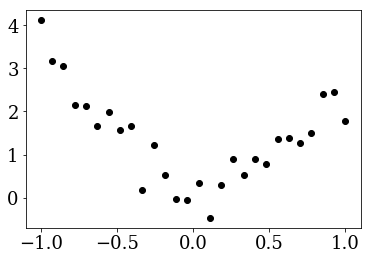

In [4]:
plt.plot(x, y_true, linestyle='', marker='o', color='black')

In [5]:
def polynomial_model(order, coef, x):
    
    if len(coef) != order+1:
        print('Please correct polynomial order!')
        return
    
    y_pred = np.zeros(shape=len(x))
    for i,c in enumerate(coef):
        y_pred += c*np.power(x,i)
    
    return y_pred

def mean_squared_error(y_true, y_pred):
    return np.average((y_true-y_pred)**2)

In [6]:
polynomial_model(1, [0.0, 1.0], [0.9, 1.1, 1.3])

array([ 0.9,  1.1,  1.3])

In [7]:
mean_squared_error(y_true, polynomial_model(1, [-0.1, 1.0], x))

4.0945147034241325

In [8]:
from scipy.optimize import minimize

In [9]:
MAX_ORDER = 9

results = {}

for order in range(1,MAX_ORDER+1):
    results[order] = minimize(fun=lambda p: mean_squared_error(y_true, polynomial_model(order, p, x)),
                                x0=np.zeros(shape=order+1))

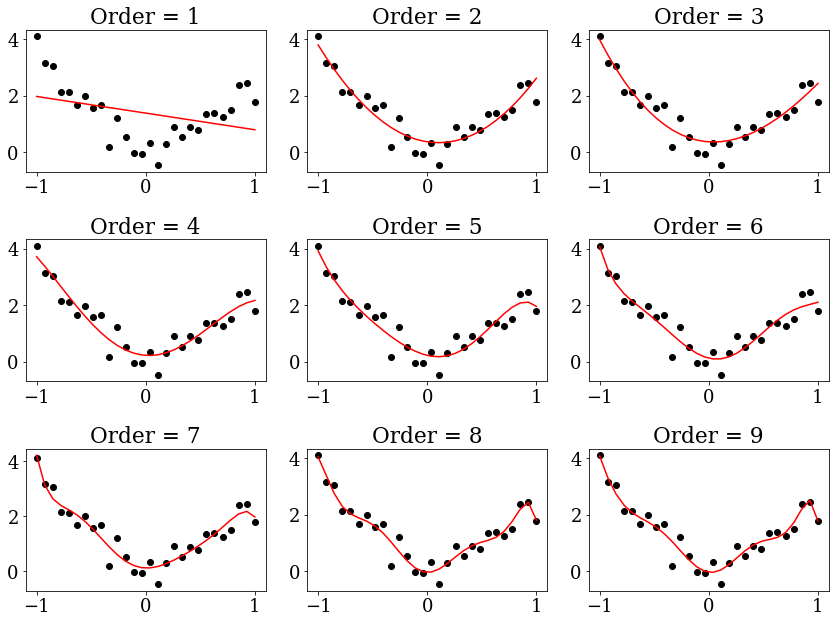

In [10]:
n_col = 3
n_row = np.ceil((MAX_ORDER-1)/n_col)+1
plt.figure(figsize=(n_col*4, n_row*3))

for order in results.iterkeys():
    plt.subplot(n_row, n_col, order)
    plt.plot(x, y_true, linestyle='', marker='o', color='black')
    plt.plot(x, polynomial_model(order, results[order].x, x), color='red')
    plt.title('Order = %d' % order)
    
plt.tight_layout()

In [11]:
from sklearn.utils import shuffle

def setup_dataframe(n_folds, x, y, shuf=False):
    if len(y) % n_folds != 0:
        print('Data (%d) is not divisible into %d folds.' % (len(y), n_folds))
        return 
    
    x = x.transpose()
    y = y.transpose()
    
    d  = {'x':x, 'y':y}
    df = pd.DataFrame(data=d)
    
    if shuf is True:
        df = shuffle(df)

    chunk_size = int(len(y)/n_folds) 
    
    a = np.arange(0,n_folds)
    df['chunk'] = np.repeat(a,chunk_size)
    return df

def cross_validate(n_folds, order, df):

    validation_scores = []
    parameters = []
    for i in range(n_folds):
        res = minimize(fun=lambda p: np.average((df.query('chunk != %d' % i).y - polynomial_model(order, p, df.query('chunk != %d' % i).x))**2), 
                                    x0=np.zeros(shape=order+1)
                                   )
        
        y_pred = polynomial_model(order, res.x, df.query('chunk == %d' % i).x)
        validation_scores.append(np.average((df.query('chunk == %d' % i).y-y_pred)**2))
        parameters.append(res.x)
        
    return np.array(validation_scores), parameters

In [12]:
# LOOCV is 28
#CHUNKS = 28
CHUNKS = 4
cv     = {}
params = {}

df = setup_dataframe(CHUNKS, x, y_true, shuf=False)

for order in range(1,MAX_ORDER+1):
    print('Processing order %d' % order)
    cv[order], params[order] = cross_validate(CHUNKS, order, df)

Processing order 1
Processing order 2
Processing order 3
Processing order 4
Processing order 5
Processing order 6
Processing order 7
Processing order 8
Processing order 9


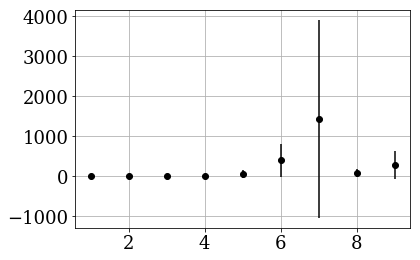

In [13]:
plt.errorbar(cv.keys(), np.average(cv.values(), axis=1), np.std(cv.values(), axis=1),
            linestyle='', marker='o', color='black')
plt.grid()

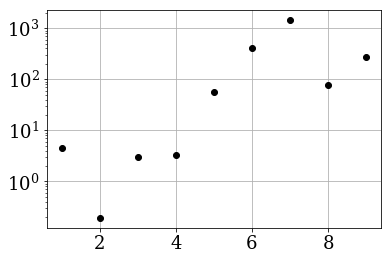

In [14]:
plt.semilogy(cv.keys(), np.average(cv.values(), axis=1),
            linestyle='', marker='o', color='black')
plt.grid()

In [15]:
for order in range(1,MAX_ORDER+1):
    for k in range(CHUNKS):
        print(order, k, params[order][k])

(1, 0, array([ 0.74627287,  0.88461781]))
(1, 1, array([ 1.66870517, -0.74973504]))
(1, 2, array([ 1.65288001, -0.43436022]))
(1, 3, array([ 0.72556847, -2.08709537]))
(2, 0, array([ 0.36683091, -0.58394167,  2.83221989]))
(2, 1, array([ 0.43051454, -0.58090909,  2.73340784]))
(2, 2, array([ 0.37780357, -0.60821375,  2.81484255]))
(2, 3, array([ 0.29427758, -0.4178174 ,  3.21929489]))
(3, 0, array([ 0.11265922, -0.05211996,  5.42725331, -3.33644277]))
(3, 1, array([ 0.33478215, -0.01590903,  2.85910507, -0.81386693]))
(3, 2, array([ 0.45065694, -0.17834041,  2.71918055, -0.61921132]))
(3, 3, array([ 0.20791419, -0.59852358,  4.10101593,  1.13364358]))
(4, 0, array([ 0.11171642, -0.33144345,  5.58381377, -1.86242489, -1.42141681]))
(4, 1, array([ 0.16297233,  0.04428064,  4.07025725, -0.89161865, -1.23908229]))
(4, 2, array([ 0.27311177, -0.24053545,  3.97080797, -0.53887674, -1.2805019 ]))
(4, 3, array([ 0.20907248, -0.94725126,  3.90584018,  2.97397252,  1.77431818]))
(5, 0, array([ 0

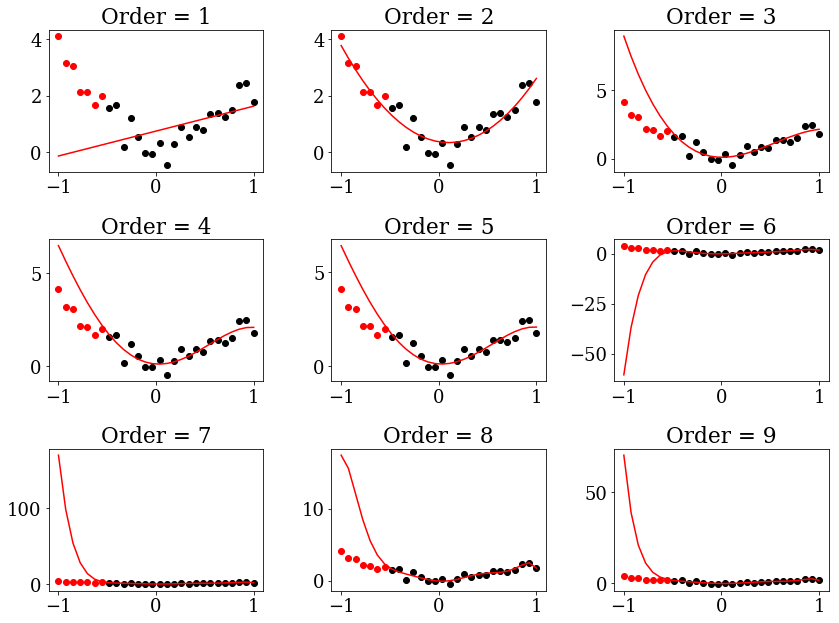

In [16]:
n_col = 3
n_row = np.ceil((MAX_ORDER-1)/n_col)+1
plt.figure(figsize=(n_col*4, n_row*3))

train = df.query('chunk != 0')
test  = df.query('chunk == 0')

for order in range(1,MAX_ORDER+1):
    plt.subplot(n_row, n_col, order)
    plt.plot(train.x, train.y, linestyle='', marker='o', color='black')
    plt.plot(test.x, test.y, linestyle='', marker='o', color='red')
    plt.plot(x, polynomial_model(order, params[order][0], x), color='red')
    plt.title('Order = %d' % order)
    
plt.tight_layout()

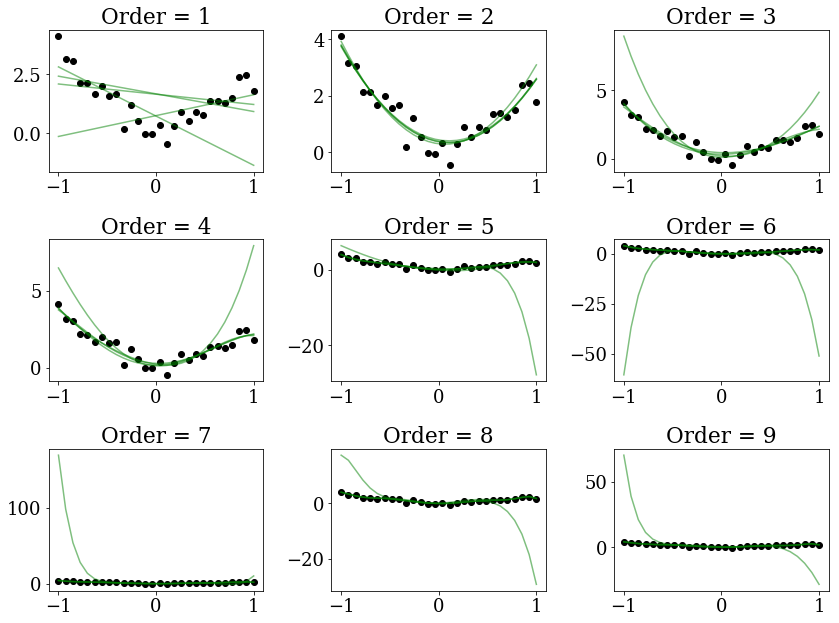

In [17]:
n_col = 3
n_row = np.ceil((MAX_ORDER-1)/n_col)+1
plt.figure(figsize=(n_col*4, n_row*3))

train = df.query('chunk != 1')
test  = df.query('chunk == 1')

for order in range(1,MAX_ORDER+1):
    plt.subplot(n_row, n_col, order)
    plt.plot(df.x, df.y, linestyle='', marker='o', color='black')
    
    for pars in params[order]:
        plt.plot(x, polynomial_model(order, pars, x), color='green', alpha=0.5)
        
    plt.title('Order = %d' % order)
    
plt.tight_layout()